<a href="https://colab.research.google.com/github/deloragaskins/data_science_public/blob/learning_goals/independent_study/Chem_Ash_2_masked_token_simple_benzene_derivatives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Abstract

In this notebook, ChemBERTa is used to predict masked tokens of the SMILES representation of benzene and phenol using transformers. The position of the mask was found to affect whether the correct or reasonable structures were generated. 

## About ChemBERTA
Further details from [Reference](https://github.com/deepchem/deepchem/blob/ac2951baf5e2acccd0267ce5c84e2ba02473f368/examples/tutorials/Transfer_Learning_With_ChemBERTa_Transformers.ipynb) are quoted below. 
> The default tokenizer used by ChemBERTa, is a Byte-Pair-Encoder (BPE). It is a hybrid between character and word-level representations, which allows for the handling of large vocabularies in natural language corpora. Motivated by the intuition that rare and unknown words can often be decomposed into multiple known subwords, BPE finds the best word segmentation by iteratively and greedily merging frequent pairs of characters. Using the same pre-training procedure used by RoBERTa, a follow-up work of BERT, which masks 15% of the tokens, we mask 15% of the tokens in each SMILES string and assign a maximum sequence length of 256 characters.

> The model then learns to predict masked tokens consisting of atoms and functional groups, or specific groups of atoms within molecules which have their own characteristic properties. Through this, the model learns the relevant molecular context for transferable tasks, such as property prediction.

> ChemBERTa employs a bidirectional training context to learn context-aware representations of the PubChem 10M dataset, downloadable through MoleculeNet for self-supervised pre-training (link). Our variant of the BERT transformer uses 12 attention heads and 6 layers, resulting in 72 distinct attention mechanisms.

<!-- Now, to ensure our the ChemBERTa model demonstrates an understanding of chemical syntax and molecular structure, we'll be testing it on predicting a masked token/character within the SMILES molecule for benzene and simple derivatives. Using the Huggingface pipeline we initialized earlier we can fetch a list of the model's predictions. -->

#preamble


In [1]:
!pip install --pre deepchem
!pip install rdkit-pypi

#to access ClinTox_
# import MolNet dataloder from bert-loves-chemistry fork
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git
%cd /content/bert-loves-chemistry
!pwd
from chemberta.utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop

#to play with chemical structures
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import Draw as ChemDraw
from rdkit.Chem.Draw import MolToImage

#for display
import matplotlib.pyplot as plt
from matplotlib import colors


fatal: destination path 'bert-loves-chemistry' already exists and is not an empty directory.
/content/bert-loves-chemistry
/content/bert-loves-chemistry


In [2]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install transformers

from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer
from bertviz import head_view

import torch


FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo


In [3]:
def predict_n(sequence,n):
  input = tokenizer.encode(sequence, return_tensors="pt")
  mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

  token_logits = model(input)[0]
  mask_token_logits = token_logits[0, mask_token_index, :]
  top_n_tokens = torch.topk(mask_token_logits, n, dim=1).indices[0].tolist()
  #print(top_n_tokens)

  valid_mols_list=[]
  for token in top_n_tokens:
    smi = (sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))
    #print (smi)
    smi_mol = Chem.MolFromSmiles(smi)
    if smi_mol is None: # if the model's token prediction isn't chemically feasible
      continue
    valid_mols_list.append(Chem.AddHs(smi_mol))
  return valid_mols_list

def addmask(molecule_str,mask_str,mask_start_pos,mask_end_pos):
  masked=''
  for counter0 in range(len(molecule_str)):
    if mask_len>0:
      if counter0 in range(mask_start_pos,mask_end_pos):
        masked+=''
      elif counter0 == mask_end_pos:
        masked+=mask_str
      else:
        masked+=molecule_str[counter0]
    else:
        masked+=molecule_str[counter0]
  #print(masked)
  return masked
    

select the pretrained model

In [4]:
#train the model and define the pipeline
model = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)

Make predictions for the molecules that are generated when the mask is in the place of the Carbon atom, bonds, ring closures. Additionally mask the position prior to the first carbon which would represent a substituent at that carbon. 

We are able to see in figure 1 that the molecule benzene is found as a potential candidate when the rind closure or double bond tokens are masked, however it's not found when the Carbon atoms are masked. In these cases there is an extension of the side of the ring. Phenol was not obtained in the top 5 predictions when the mask was placed prior to the first carbon. 


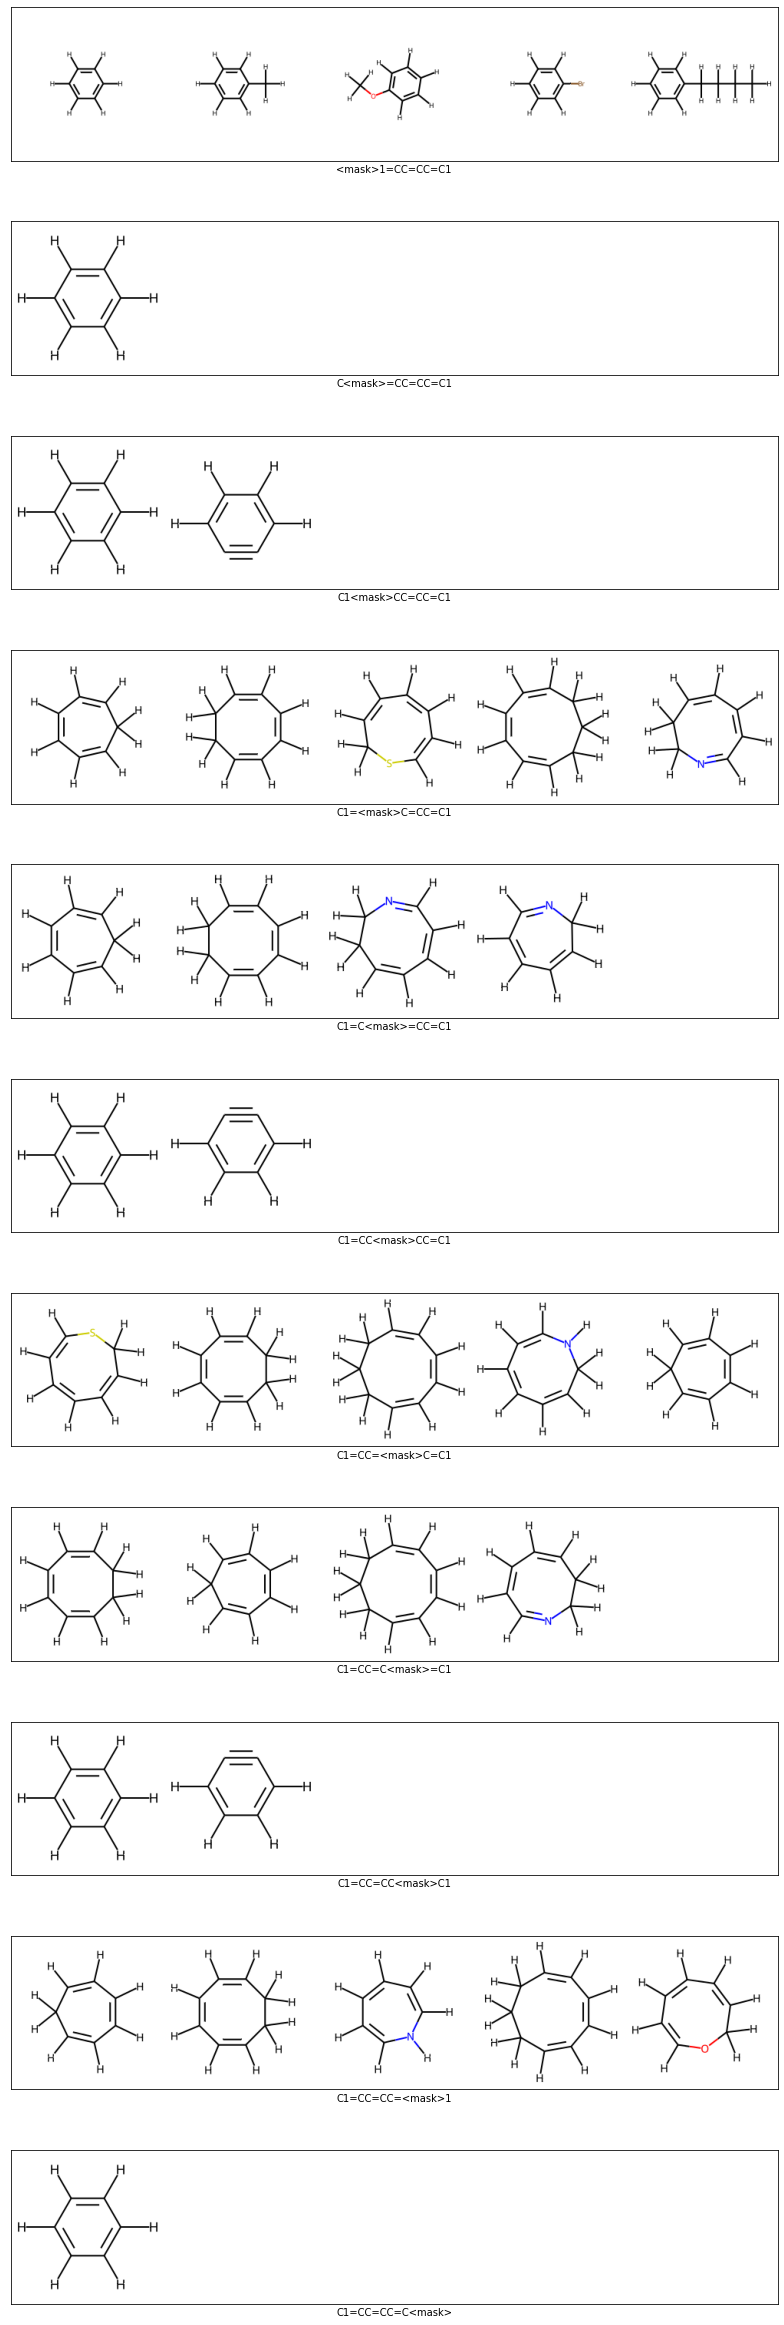

In [5]:
#Make and display valid predictions for single masked position 
molecule_str="C1=CC=CC=C1"
img_list=[]
mask_list=[]
for counter1 in range(len(molecule_str)):
  mask_start_pos=counter1
  mask_end_pos=mask_start_pos
  mask_len=mask_end_pos-mask_start_pos+1
  mask_str='<mask>'

  smiles_mask=addmask(molecule_str,mask_str,mask_start_pos,mask_end_pos)
  
  sequence = smiles_mask.replace('<mask>',tokenizer.mask_token)
  n=5
  valid_mols_list=predict_n(sequence,n)
  #valid_mols_list.insert(0, Chem.AddHs(Chem.MolFromSmiles(smiles_org)))
  mask_list.append(smiles_mask)
  img_list.append(ChemDraw.MolsToGridImage(valid_mols_list,molsPerRow=5))

length_peek=len(img_list)
size_adj_x=3
size_adj_y=1
Fig1=plt.figure(figsize=(length_peek*size_adj_y,length_peek*size_adj_x))

number_of_rows=length_peek
number_of_columns=1
for counter0 in range(length_peek):
  plt.subplot(number_of_rows,number_of_columns,counter0+1)
  plt.imshow(img_list[counter0])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(mask_list[counter0])
plt.tight_layout()

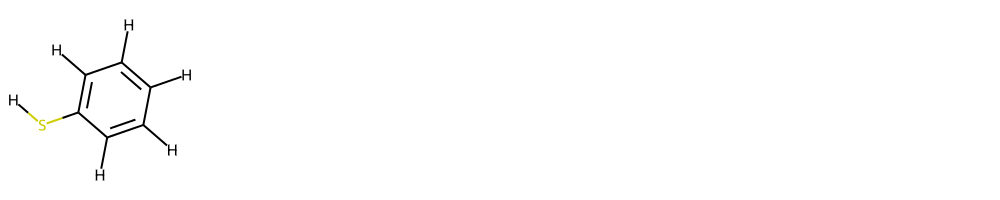

In [6]:
#Make and display valid predictions for substituent
smiles_org = "(OH)C1=CC=CC=C1"
smiles_mask = "<mask>C1=CC=CC=C1"
sequence = smiles_mask.replace('<mask>',tokenizer.mask_token)
n=5
valid_mols_list=predict_n(sequence,n)
#valid_mols_list.insert(0, Chem.AddHs(Chem.MolFromSmiles(smiles_org)))
ChemDraw.MolsToGridImage(valid_mols_list,molsPerRow=5)